In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from datetime import datetime, timedelta

from control.modules.pvt import PvtControl, PvtParameters
from input_output.alarms import BaseAlarms
from input_output.base import Stamped, StampedDf
from input_output.definitions.control import Valve
from input_output.definitions.simulation import (
    Boundary,
    HeatSource,
    TemperatureBoundary,
    ValvePosition,
)

from input_output.modules.pvt import (
    PvtControlValues,
    PvtSensorValues,
    PvtSimulationInputs,
    PvtSimulationOutputs,
)
from orchestration.simulator import Simulator, SimulatorModel
from simulation.models.fmu_paths import pvt_path
import polars as pl

start_time = datetime.fromtimestamp(0)
duration = timedelta(minutes=59)
time_index = pl.datetime_range(
    start_time, start_time + duration, interval="1m", time_unit="us", eager=True
)


pvt_main_heat = StampedDf.stamp(
    pl.DataFrame({"time": time_index, "value": 2 * [0.0] + 58 * [1600.0] })
)

pvt_owners_heat = StampedDf.stamp(
    pl.DataFrame({"time": time_index, "value": 2 * [0.0] + 58 * [8000.0]})
)





simulation_inputs = PvtSimulationInputs(
    pvt_main_fwd=HeatSource(heat_flow=pvt_main_heat),
    pvt_main_aft=HeatSource(heat_flow=pvt_main_heat),
    pvt_owners=HeatSource(heat_flow=pvt_owners_heat),
    pvt_pump_failure_switch_main_fwd=ValvePosition(
        position_rel=Stamped.stamp(Valve.CLOSED)
    ),
    pvt_pump_failure_switch_main_aft=ValvePosition(
        position_rel=Stamped.stamp(Valve.CLOSED)
    ),
    pvt_pump_failure_switch_owners=ValvePosition(
        position_rel=Stamped.stamp(Valve.CLOSED)
    ),
    pvt_module_supply=TemperatureBoundary(temperature=Stamped.stamp(65)),
    pvt_seawater_supply=Boundary(temperature=Stamped.stamp(32), flow=Stamped.stamp(10)),
)

control = PvtControl(PvtParameters())

pvt_model = SimulatorModel(
    fmu_path=pvt_path,
    sensor_values_cls=PvtSensorValues,
    control_values_cls=PvtControlValues,
    simulation_outputs_cls=PvtSimulationOutputs,
    simulation_inputs=simulation_inputs,
    control=control,
    alarms=BaseAlarms(),
    tick_duration=timedelta(seconds=1),
    start_time=start_time,
)

simulation = Simulator(pvt_model)

result = await simulation.run(2*60)

control.to_recovery()

result2 = await simulation.run(57*60)

result = result.vstack(result2)

[WARNING] Warning: The following was detected at time: 3.953987524092337E-28
[WARNING]   PVT_panels_Module_FMU.pvt_panels.pvt_mix_main_aft_split: Flow splitRatio is far above 1. But it must be between 0 and 1. (is 131)
  Failed condition: pvt_panels.pvt_mix_main_aft_split.splitRatio_ <= 1.001

[WARNING] Warning: The following was detected at time: 3.953987524092337E-28
[WARNING]   PVT_panels_Module_FMU.pvt_panels.flowSplit_aft_supply: Flow splitRatio is negative and far below 0. But it must be between 0 and 1. (is -0.345972)
  Failed condition: pvt_panels.flowSplit_aft_supply.splitRatio_ >= -0.001

[WARNING] Warning: The following was detected at time: 3.953987524092337E-28
[WARNING]   PVT_panels_Module_FMU.pvt_panels.flowJoin_main_aft: Flow splitRatio is negative and far below 0. But it must be between 0 and 1. (is -44)
  Failed condition: pvt_panels.flowJoin_main_aft.splitRatio >= -0.001

[WARNING] Warning: The following was detected at time: 3.953987524092337E-28
[WARNING]   PVT_pan

/var/folders/w7/x3ddjmps2dvfqdrygwzccnd00000gn/T/ipykernel_71735/742455561.py:82: CategoricalRemappingWarning: Local categoricals have different encodings, expensive re-encoding is done to perform this merge operation. Consider using a StringCache or an Enum type if the categories are known in advance
  result = result.vstack(result2)


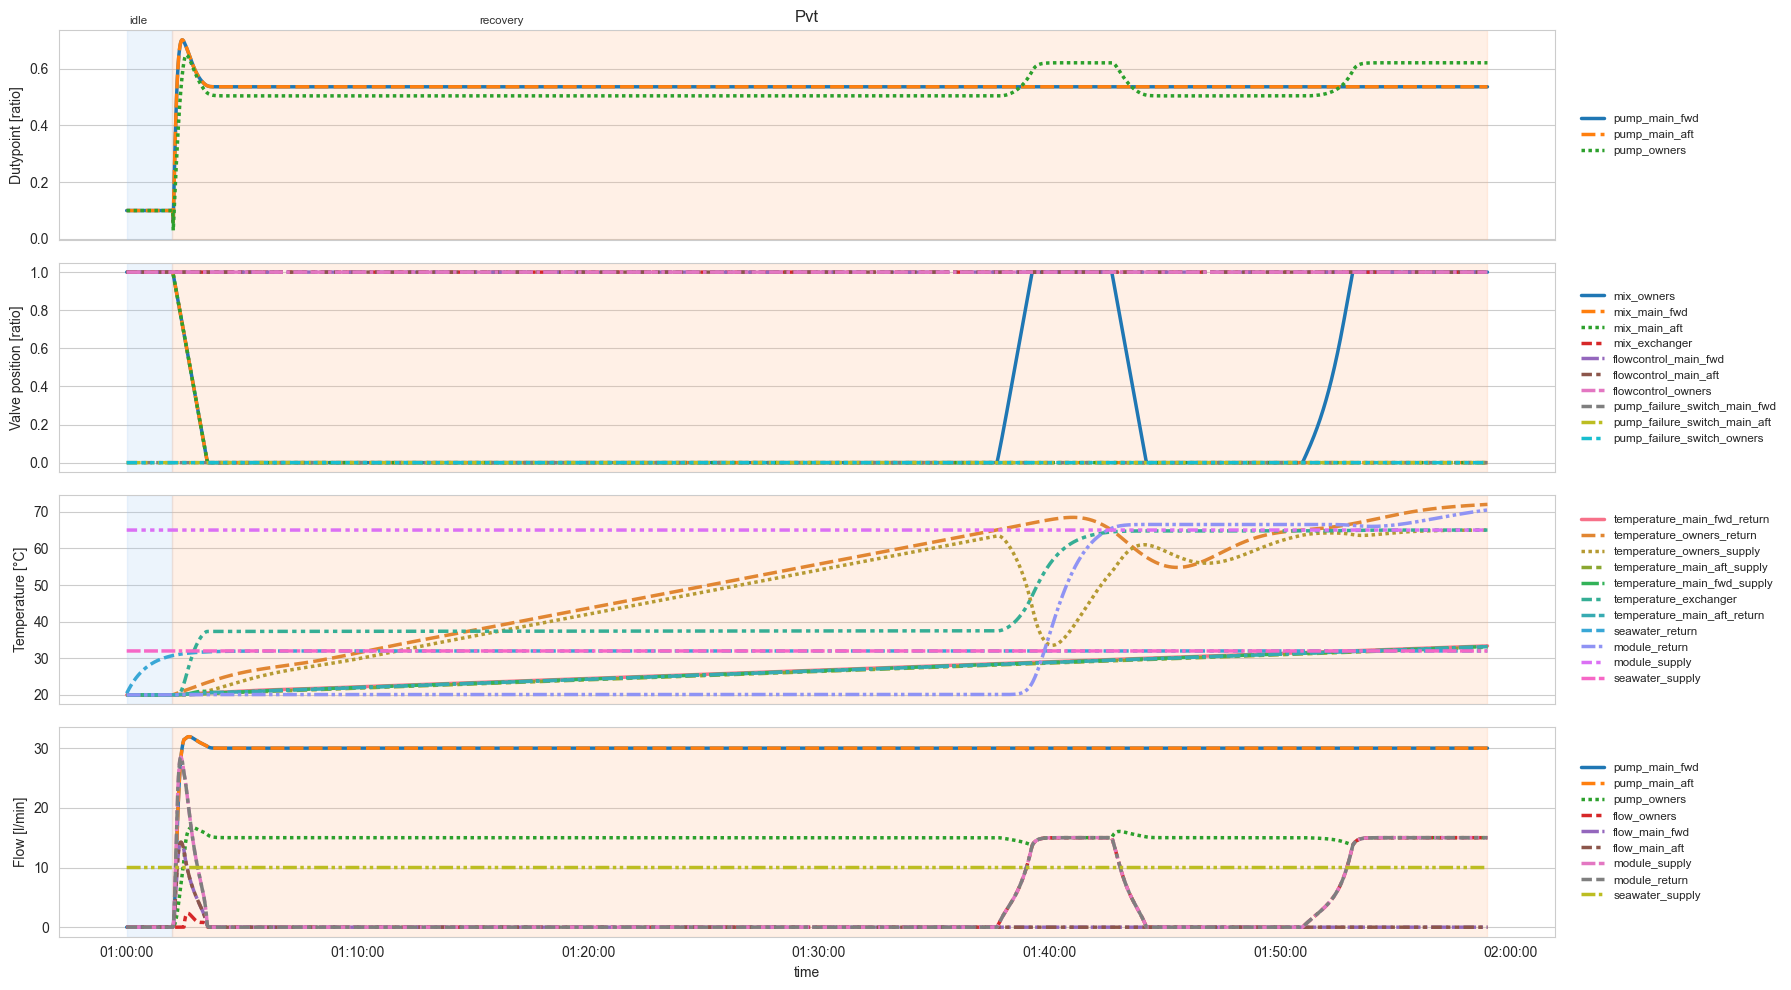

In [3]:
from analysis.analysis_utils import plot_result

plot_result(result, 'plots/pvt.png');